In [ ]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git
!pip install imgaug
!pip install -U opencv-python

!gdown --id 1S_vKl5E1z7yK7KQyHVTmwacWHlfmohV1 #download detector weights
!gdown --id 1CoHp2jck0GK8ogkazgaACV5o4F0SoMCD #download recognizer weights
!gdown --id 1SE3TSVITtvqOe_wPfrOHkEaIbg9G93tF #download test foto obat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-req-build-tl6ngjbj
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-req-build-tl6ngjbj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 930 kB 5.0 MB/s 
     |████████████████████████████████| 9.5 MB 27.6 MB/s 
     |████████████████████████████████| 603 kB 38.9 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.9.0.post2+40bb9bd-py3-none-any.whl size=42441 sha256=395ed38f34cb967c37e2cf7ce5f322a5231d7070ae68addf74cc2ca4a5851340
  Stored in directory: /tmp/pip-ephem-wheel-cache-oa1b_rab/wheels/20/d0/06/ed290995144ec8dde71d3a91d0d590145445c01be60ea70c9b
  Created wheel for validators: filename=validators-0.20

In [ ]:
!unzip "/content/test_obat.zip"

Archive:  /content/test_obat.zip
  inflating: Acarbose.jpg            
  inflating: Cetirizine.jpg          
  inflating: Decolgen.jpg            
  inflating: Decolgen_crop.jpg       
  inflating: Decolsin.jpg            
  inflating: Decolsin_2.jpg          
  inflating: Panadol.jpg             
  inflating: Paramex.jpg             
  inflating: Paramex_2.jpg           
  inflating: Promag.jpg              


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import string
import cv2

import keras_ocr

dir = "."

**CONVERTING DETECTOR TO TFLITE**

In [ ]:
detector = keras_ocr.detection.Detector()
detector.model.load_weights(os.path.join(dir, "detector_icdar2013.h5"))

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [ ]:
quantization = "float16"

detector_converter = tf.lite.TFLiteConverter.from_keras_model(detector.model)
detector_converter.optimizations = [tf.lite.Optimize.DEFAULT]
detector_converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]

detector_converter.target_spec.supported_types = [tf.float16]
tf_lite_model = detector_converter.convert()
with open(f"detector_pmed.tflite", "wb") as f:
    f.write(tf_lite_model)

INFO:tensorflow:Assets written to: /tmp/tmppb77uusj/assets


In [ ]:
!du -sh detector_pmed.tflite

40M	detector_pmed.tflite


In [ ]:
from google.colab import files
files.download('/content/detector_pmed.tflite') 

**CONVERTING RECOGNIZER TO TFLITE**

In [ ]:
alphabet = string.digits + string.ascii_letters + '!?., /\\"\'@()<>-'
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
blank_index = len(recognizer_alphabet)

In [ ]:
recognizer = keras_ocr.recognition.Recognizer(alphabet=recognizer_alphabet)
recognizer.model.load_weights(os.path.join(dir, "recognizer_icdar2013.h5"))

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [ ]:
quantization = "float16"

converter = tf.lite.TFLiteConverter.from_keras_model(recognizer.prediction_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]

converter.target_spec.supported_types = [tf.float16]
tf_lite_model = converter.convert()
with open(f"recognizer_pmed.tflite", "wb") as f:
    f.write(tf_lite_model)

INFO:tensorflow:Assets written to: /tmp/tmp863579fw/assets


INFO:tensorflow:Assets written to: /tmp/tmp863579fw/assets


In [ ]:
!du -sh recognizer_pmed.tflite

17M	recognizer_pmed.tflite


In [ ]:
from google.colab import files
files.download('/content/recognizer_pmed.tflite') 

**TEST RECOGNIZER TFLITE MODEL**

In [ ]:
def preprocess_image(im_path):
  input_data = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
  input_data = cv2.resize(input_data, (200, 31))
  input_data = input_data[np.newaxis]
  input_data = np.expand_dims(input_data, 3)
  input_data = input_data.astype('float32')/255 
  return input_data

In [ ]:
def run_inference(image):
  tflite_model_file = "/content/recognizer_pmed.tflite"

  interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  input_index = input_details[0]["index"]
  output_index = output_details[0]["index"]

  interpreter.set_tensor(input_index, im)
  interpreter.invoke()

  output = interpreter.get_tensor(output_index)
  return output

In [ ]:
im_path = "./Decolgen_crop.jpg"
img = preprocess_image(im_path)

In [ ]:
interpreter_output = run_inference(img)
output = "".join(recognizer_alphabet[index] for index in interpreter_output[0] if index not in [blank_index, -1])

decolgen


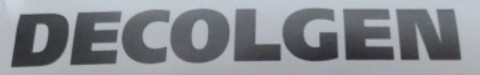

In [ ]:
print(output)
from google.colab.patches import cv2_imshow
im = cv2.imread(im_path)
cv2_imshow(im)